# Spin test 2

In [89]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [90]:
video_number = "3"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 227.0


Import data

In [91]:
# Define the path to the CSV file
input_data_path = project_root / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_cleaned_{video_number}.csv"

# Load the CSV file into a DataFrame
ball_df = pd.read_csv(input_data_path)

Select a Frame

In [92]:
# Set the video to the 30th frame (frame index starts from 0)
frame_number = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

# Check if the frame was successfully read
if ret:
    print(f"Frame {frame_number} successfully read.")
else:
    print(f"Failed to read frame {frame_number}.")

Frame 100 successfully read.


Optical flow

66 66
64 64


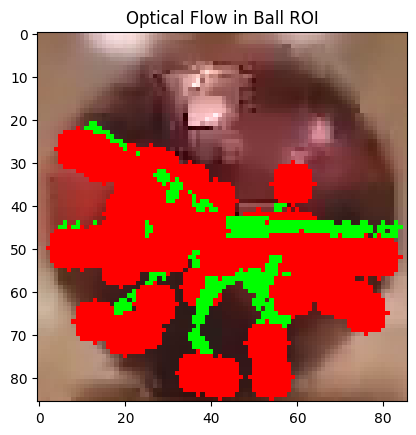

In [93]:
# Extract ball center and radius from ball_df
ball_center = (int(ball_df.iloc[frame_number]['x']), int(ball_df.iloc[frame_number]['y']))
ball_radius = int(ball_df.iloc[frame_number]['radius'])

offset = 2

# Define the region of interest (ROI) around the ball
x_min = max(ball_center[0] - ball_radius, 0)-offset
x_max = min(ball_center[0] + ball_radius, frame.shape[1])+offset
y_min = max(ball_center[1] - ball_radius, 0)-offset
y_max = min(ball_center[1] + ball_radius, frame.shape[0])+offset
roi = frame[y_min:y_max, x_min:x_max]
copy_roi = roi.copy()
ball_center_roi = (ball_center[0] - x_min+offset, ball_center[1] - y_min+offset)
# Convert ROI to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# selezione 100 punti manuali distribuiti su 10 cerchi concentrici
manual_points = []
num_rings = 10  # numero di cerchi concentrici
points_per_ring = 10  # punti per ogni cerchio (10 × 10 = 100)
max_radius = ball_radius * 0.95  # lascia un margine vicino al bordo

for i in range(1, num_rings + 1):
    r = (i / num_rings) * max_radius
    for j in range(points_per_ring):
        if j<7 or j>9:
            theta = 2 * np.pi * j / points_per_ring
            x = int(ball_center_roi[0] + r * np.cos(theta))
            y = int(ball_center_roi[1] + r * np.sin(theta))
            manual_points.append((x, y))

# Converti in formato richiesto da calcOpticalFlowPyrLK
p0 = np.array(manual_points, dtype=np.float32).reshape(-1, 1, 2)

# Read the next frame for optical flow calculation
ret, next_frame = cap.read()
if not ret:
    raise ValueError(f"Failed to read the next frame after frame {frame_number}.")

# calculate the next ball center
ball_center_next = (int(ball_df.iloc[frame_number + 1]['x']), int(ball_df.iloc[frame_number + 1]['y']))
# as radius I need to use the previous in ordet to have roi of the same size

# Define the next ROI around the ball in the next frame
x_min_next = max(ball_center_next[0] - ball_radius, 0)-offset
x_max_next = min(ball_center_next[0] + ball_radius, next_frame.shape[1])+offset
y_min_next = max(ball_center_next[1] - ball_radius, 0)-offset
y_max_next = min(ball_center_next[1] + ball_radius, next_frame.shape[0])+offset
next_roi = next_frame[y_min_next:y_max_next, x_min_next:x_max_next]
ball_center_next_roi = (ball_center_next[0] - x_min_next, ball_center_next[1] - y_min_next)

next_roi_gray = cv2.cvtColor(next_roi, cv2.COLOR_BGR2GRAY)

# Calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(roi_gray, next_roi_gray, p0, None, **lk_params)

# store the flow vectors
flow_vectors = [] 

# Filter good points
if p1 is not None and st is not None:
    # # get the indeces where st==1 and err<10 -> more filtering
    # good_indices = np.where((st.flatten() == 1) & (err < 20))[0]
    # good_new = p1[good_indices].reshape(-1, 2)
    # good_old = p0[good_indices].reshape(-1, 2)
    # err_good = err[good_indices]
    # print(good_indices)

    good_new = p1[st == 1].reshape(-1, 2)
    good_old = p0[st == 1].reshape(-1, 2)
    print(len(good_new), len(good_old))

    # Filter only the point in the ball
    # Compute distances to the ball center
    dist_old = np.linalg.norm(good_old[:, :] - ball_center_roi, axis=1)
    dist_new = np.linalg.norm(good_new[:, :] - ball_center_next_roi, axis=1)

    # Create a mask of points that are within the ball in both frames
    within_radius_mask = (dist_old <= ball_radius) & (dist_new <= ball_radius)

    # Apply the mask
    good_old = good_old[within_radius_mask].reshape(-1, 2)
    good_new = good_new[within_radius_mask].reshape(-1, 2)

    print(len(good_new), len(good_old))


    # Visualize the optical flow
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        cv2.line(roi, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        cv2.circle(roi, (int(a), int(b)), 5, (0, 0, 255), -1)
        flow_vectors.append({
            'frame': frame_number,
            'point_id': i,
            'x_old': c,
            'y_old': d,
            'x_new': a,
            'y_new': b,
            'dx': a - c,
            'dy': b - d
        })
        # print(f"Point {i}: Old: ({c}, {d}), New: ({a}, {b}), dx: {a - c}, dy: {b - d}")

    # Display the ROI with optical flow
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title("Optical Flow in Ball ROI")
    plt.show()
else:
    print("No optical flow points detected.")

Compute rotation and axis

In [94]:
distances = np.linalg.norm(good_new - good_old, axis=1)
velocities = distances / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to velocity in pixels per second
z_3d_old = np.sqrt(ball_radius**2 - (good_old[:, 0]-ball_center_roi[0])**2 - (good_old[:, 1]-ball_center_roi[1])**2)
points_3d_old = np.array([good_old[:, 0], good_old[:, 1], z_3d_old]).T

z_3d_new = np.sqrt(ball_radius**2 - (good_new[:, 0]-ball_center_next_roi[0])**2 - (good_new[:, 1]-ball_center_next_roi[1])**2)
points_3d_new = np.array([good_new[:, 0], good_new[:, 1], z_3d_new]).T

# Calculate the 3D velocity vectors
velocity_vectors_3d = points_3d_new - points_3d_old


In [95]:
'''for each point in points_3d_new, calculate its projection on the plane tangen to the ball surface 
    in the corrspondent poin in points_3d_old
the projection is done by calculating the normal vector to the ball surface in the point of interest and 
    then projecting the point on this plane
the normal vector is given by the vector from the center of the ball to the point of interest
'''
# normal vectors to the ball surface in the point of interest
normal_vectors = points_3d_old / np.linalg.norm(points_3d_old, axis=1)[:, np.newaxis]  

# projection of the points on the plane tangent to the ball surface in the point of interest (they are the difference, not the points)
projection_vectors = points_3d_new - np.sum(points_3d_new * normal_vectors, axis=1)[:, np.newaxis] * normal_vectors
# print(projection_vectors)

projected_points_new = points_3d_old + projection_vectors

idx = 7
print('old points', points_3d_old[idx])
print('vectors', projection_vectors[idx])
print('projected points', projected_points_new[idx])


old points [52.       45.       40.398018]
vectors [-5.7856903  6.3712387  0.3502617]
projected points [46.21431 51.37124 40.74828]


In [96]:
def estimate_rotation_matrix(P, Q):
    """
    Estimate rotation matrix that aligns P to Q (P and Q are Nx3)
    """
    assert P.shape == Q.shape
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    
    # Center the points
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q
    
    # Compute covariance matrix
    H = P_centered.T @ Q_centered

    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Handle reflection (if determinant is negative)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    return R

R = estimate_rotation_matrix(points_3d_old, projected_points_new)
print("Rotation matrix:\n", R)
# Calculate the rotation angles around each axis (in radians)
angles = np.arctan2(R[2, 1], R[2, 2]), np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2)), np.arctan2(R[1, 0], R[0, 0])
angles_deg = np.degrees(angles)  # convert to degrees
print("Rotation angles (degrees):", angles_deg)

# Compute the angular velocity vector (in radiant per second)
angular_velocity = np.array([angles[0], angles[1], angles[2]]) / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to angular velocity in degrees per second
print("Angular velocity (rad/s):", angular_velocity)

# compute the vector magnitude
angular_velocity_magnitude = np.linalg.norm(angular_velocity)
print("Angular velocity magnitude (rad/s):", angular_velocity_magnitude)

# Compute the axis of rotation (in 3D space)
axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
print("Axis of rotation (3D):", axis_of_rotation)

# Compute the intersection of the axis of rotation with the ball surface
# Normalize the axis of rotation
axis_of_rotation_normalized = axis_of_rotation / np.linalg.norm(axis_of_rotation)
# Compute the intersection point on the ball surface
intersection_point_1 = ball_radius * axis_of_rotation_normalized
intersection_point_2 = - ball_radius * axis_of_rotation_normalized 

# I want to chose the intersection point that has positive z coordinate
intersection_point = intersection_point_1 if intersection_point_1[2] > 0 else intersection_point_2
print("Intersection point on the ball surface (3D):", intersection_point)

# Get the intersection point in 2D:
intersection_point_2d = intersection_point[:2] + ball_center_roi
print("Intersection point on the ball surface (2D):", intersection_point_2d)

Rotation matrix:
 [[ 0.9986664   0.04948438  0.01472048]
 [-0.0487508   0.9977235  -0.04659535]
 [-0.01699271  0.04581558  0.99880534]]
Rotation angles (degrees): [ 2.6263378   0.97365737 -2.7947264 ]
Angular velocity (rad/s): [ 2.7475471  1.0185932 -2.923707 ]
Angular velocity magnitude (rad/s): 4.139397
Axis of rotation (3D): [ 30.825806  22.716919 -76.05298 ]
Intersection point on the ball surface (3D): [-14.842907 -10.938403  36.620205]
Intersection point on the ball surface (2D): [30.15709305 34.06159687]


Generate video

In [97]:
output_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_video_modified_{video_number}.mp4"

# Ottieni le proprietà del video originale
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Inizializza il VideoWriter
out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

# Riposiziona il video all'inizio
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Itera su tutti i frame del video
frame_idx = 0
while True:
# for i in range(151):
    ret, frame = cap.read()
    if not ret:
        break

    # Controlla se il dato radius è presente per il frame corrente
    if frame_idx < len(ball_df) and not pd.isna(ball_df.iloc[frame_idx]['radius']) and not pd.isna(ball_df.iloc[frame_idx+1]['radius']):
        # Extract ball center and radius from ball_df
        ball_center = (int(ball_df.iloc[frame_idx]['x']), int(ball_df.iloc[frame_idx]['y']))
        ball_radius = int(ball_df.iloc[frame_idx]['radius'])

        offset = 2

        # Define the region of interest (ROI) around the ball
        x_min = max(ball_center[0] - ball_radius, 0)-offset
        x_max = min(ball_center[0] + ball_radius, frame.shape[1])+offset
        y_min = max(ball_center[1] - ball_radius, 0)-offset
        y_max = min(ball_center[1] + ball_radius, frame.shape[0])+offset
        roi = frame[y_min:y_max, x_min:x_max]
        copy_roi = roi.copy()
        ball_center_roi = (ball_center[0] - x_min+offset, ball_center[1] - y_min+offset)
        # Convert ROI to grayscale
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Parameters for optical flow
        lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

        # selezione 100 punti manuali distribuiti su 10 cerchi concentrici
        manual_points = []
        num_rings = 10  # numero di cerchi concentrici
        points_per_ring = 10  # punti per ogni cerchio (10 × 10 = 100)
        max_radius = ball_radius * 0.95  # lascia un margine vicino al bordo

        for i in range(1, num_rings + 1):
            r = (i / num_rings) * max_radius
            for j in range(points_per_ring):
                if j<20 or j>9:
                    theta = 2 * np.pi * j / points_per_ring
                    x = int(ball_center_roi[0] + r * np.cos(theta))
                    y = int(ball_center_roi[1] + r * np.sin(theta))
                    manual_points.append((x, y))

        # Converti in formato richiesto da calcOpticalFlowPyrLK
        p0 = np.array(manual_points, dtype=np.float32).reshape(-1, 1, 2)

        # Calcola il flusso ottico per il frame corrente
        if frame_idx + 1 < len(ball_df):
            # print(f"Processing frame {frame_idx}...")
            ball_center_next = (int(ball_df.iloc[frame_idx + 1]['x']), int(ball_df.iloc[frame_idx + 1]['y']))
            x_min_next = max(ball_center_next[0] - ball_radius, 0) - offset
            x_max_next = min(ball_center_next[0] + ball_radius, frame.shape[1]) + offset
            y_min_next = max(ball_center_next[1] - ball_radius, 0) - offset
            y_max_next = min(ball_center_next[1] + ball_radius, frame.shape[0]) + offset
            next_roi = next_frame[y_min_next:y_max_next, x_min_next:x_max_next]
            next_roi_gray = cv2.cvtColor(next_roi, cv2.COLOR_BGR2GRAY)
            ball_center_next_roi = (ball_center_next[0] - x_min_next, ball_center_next[1] - y_min_next)

            # Calcola il flusso ottico
            p1, st, err = cv2.calcOpticalFlowPyrLK(roi_gray, next_roi_gray, p0, None, **lk_params)

            # Filtra i punti validi
            if p1 is not None and st is not None:
                good_new = p1[st == 1].reshape(-1, 2)
                good_old = p0[st == 1].reshape(-1, 2)

                # Filter only the point in the ball
                # Compute distances to the ball center
                dist_old = np.linalg.norm(good_old[:, :] - ball_center_roi, axis=1)
                dist_new = np.linalg.norm(good_new[:, :] - ball_center_next_roi, axis=1)

                # Create a mask of points that are within the ball in both frames
                within_radius_mask = (dist_old <= ball_radius) & (dist_new <= ball_radius)

                # Apply the mask
                good_old = good_old[within_radius_mask].reshape(-1, 2)
                good_new = good_new[within_radius_mask].reshape(-1, 2)

                distances = np.linalg.norm(good_new - good_old, axis=1)
                velocities = distances / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to velocity in pixels per second
                z_3d_old = np.sqrt(ball_radius**2 - (good_old[:, 0]-ball_center_roi[0])**2 - (good_old[:, 1]-ball_center_roi[1])**2)
                points_3d_old = np.array([good_old[:, 0], good_old[:, 1], z_3d_old]).T

                z_3d_new = np.sqrt(ball_radius**2 - (good_new[:, 0]-ball_center_next_roi[0])**2 - (good_new[:, 1]-ball_center_next_roi[1])**2)
                points_3d_new = np.array([good_new[:, 0], good_new[:, 1], z_3d_new]).T

                # normal vectors to the ball surface in the point of interest
                normal_vectors = points_3d_old / np.linalg.norm(points_3d_old, axis=1)[:, np.newaxis]  

                # projection of the points on the plane tangent to the ball surface in the point of interest (they are the difference, not the points)
                projection_vectors = points_3d_new - np.sum(points_3d_new * normal_vectors, axis=1)[:, np.newaxis] * normal_vectors
                # print(projection_vectors)
                projected_points_new = points_3d_old + projection_vectors

                R = estimate_rotation_matrix(points_3d_old, projected_points_new)
                # print("Rotation matrix:\n", R)
                # Calculate the rotation angles around each axis (in radians)
                angles = np.arctan2(R[2, 1], R[2, 2]), np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2)), np.arctan2(R[1, 0], R[0, 0])
                angles_deg = np.degrees(angles)  # convert to degrees
                # print("Rotation angles (degrees):", angles_deg)

                # Compute the angular velocity vector (in radiant per second)
                angular_velocity = np.array([angles[0], angles[1], angles[2]]) / (1 / cap.get(cv2.CAP_PROP_FPS))  # Convert to angular velocity in degrees per second
                # print("Angular velocity (rad/s):", angular_velocity)

                # compute the vector magnitude
                angular_velocity_magnitude = np.linalg.norm(angular_velocity)
                # print("Angular velocity magnitude (rad/s):", angular_velocity_magnitude)

                # Compute the axis of rotation (in 3D space)
                axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
                # print("Axis of rotation (3D):", axis_of_rotation)

                # Compute the intersection of the axis of rotation with the ball surface
                # Normalize the axis of rotation
                axis_of_rotation_normalized = axis_of_rotation / np.linalg.norm(axis_of_rotation)

                # Compute the intersection point on the ball surface
                intersection_point_1 = ball_radius * axis_of_rotation_normalized
                intersection_point_2 = - ball_radius * axis_of_rotation_normalized 

                # I want to chose the intersection point that has positive z coordinate
                intersection_point = intersection_point_1 if intersection_point_1[2] > 0 else intersection_point_2
                # print("Intersection point on the ball surface (3D):", intersection_point)

                # Get the intersection point in 2D:
                intersection_point_2d = intersection_point[:2] + ball_center
                # print("Intersection point on the ball surface (2D):", intersection_point_2d)

                # Add the intersection point to ball_df
                ball_df.loc[frame_idx, 'rotation_center_x'] = intersection_point_2d[0]
                ball_df.loc[frame_idx, 'rotation_center_y'] = intersection_point_2d[1]

                # Disegna il centro della palla
                cv2.circle(frame, ball_center, 5, (255, 0, 0), -1) # Blu
                
                if not np.isnan(intersection_point_2d[0]) and not np.isnan(intersection_point_2d[1]):
                    rotation_point_2d = (int(intersection_point_2d[0]), int(intersection_point_2d[1]))
                    # Disegna il centro di rotazione
                    cv2.circle(frame, rotation_point_2d, 5, (0, 255, 255), -1)  # Giallo
                    print(f"Frame {frame_idx}: Center of Rotation: {rotation_point_2d}")

    # Scrivi il frame nel video di output
    out.write(frame)

    # Incrementa l'indice del frame
    frame_idx += 1

# Rilascia le risorse
out.release()

print(f"Video annotato salvato in: {output_video_path}")

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_9600\1412887664.py:127: RuntimeWarning: Mean of empty slice.
  axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\

Frame 32: Center of Rotation: (809, 950)
Frame 33: Center of Rotation: (832, 872)
Frame 38: Center of Rotation: (852, 847)
Frame 39: Center of Rotation: (895, 809)
Frame 40: Center of Rotation: (896, 800)
Frame 41: Center of Rotation: (898, 797)
Frame 45: Center of Rotation: (908, 784)
Frame 46: Center of Rotation: (913, 780)


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_9600\1412887664.py:127: RuntimeWarning: Mean of empty slice.
  axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\

Frame 47: Center of Rotation: (947, 744)
Frame 48: Center of Rotation: (962, 733)
Frame 49: Center of Rotation: (958, 733)
Frame 53: Center of Rotation: (965, 717)
Frame 54: Center of Rotation: (970, 708)
Frame 55: Center of Rotation: (1001, 681)


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_9600\1412887664.py:127: RuntimeWarning: Mean of empty slice.
  axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\

Frame 62: Center of Rotation: (1045, 636)
Frame 63: Center of Rotation: (1036, 642)
Frame 64: Center of Rotation: (1068, 601)
Frame 65: Center of Rotation: (1057, 608)
Frame 66: Center of Rotation: (1053, 611)
Frame 67: Center of Rotation: (1055, 625)
Frame 69: Center of Rotation: (1053, 617)
Frame 70: Center of Rotation: (1079, 606)
Frame 72: Center of Rotation: (1091, 582)
Frame 73: Center of Rotation: (1092, 584)
Frame 75: Center of Rotation: (1092, 599)


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_9600\1412887664.py:127: RuntimeWarning: Mean of empty slice.
  axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\

Frame 76: Center of Rotation: (1084, 620)
Frame 77: Center of Rotation: (1070, 630)
Frame 78: Center of Rotation: (1094, 599)
Frame 79: Center of Rotation: (1088, 609)
Frame 80: Center of Rotation: (1119, 572)
Frame 81: Center of Rotation: (1119, 574)
Frame 82: Center of Rotation: (1114, 586)
Frame 83: Center of Rotation: (1119, 584)
Frame 84: Center of Rotation: (1142, 573)
Frame 85: Center of Rotation: (1104, 611)
Frame 86: Center of Rotation: (1133, 582)
Frame 87: Center of Rotation: (1131, 584)
Frame 88: Center of Rotation: (1135, 583)
Frame 89: Center of Rotation: (1131, 587)
Frame 90: Center of Rotation: (1130, 588)
Frame 91: Center of Rotation: (1147, 584)
Frame 92: Center of Rotation: (1139, 581)
Frame 93: Center of Rotation: (1142, 577)
Frame 94: Center of Rotation: (1163, 568)
Frame 95: Center of Rotation: (1171, 562)
Frame 96: Center of Rotation: (1154, 570)
Frame 97: Center of Rotation: (1154, 571)
Frame 98: Center of Rotation: (1139, 587)
Frame 99: Center of Rotation: (114

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Temp\ipykernel_9600\1412887664.py:127: RuntimeWarning: Mean of empty slice.
  axis_of_rotation = np.cross(points_3d_old.mean(axis=0), projected_points_new.mean(axis=0))
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\

Frame 149: Center of Rotation: (1230, 475)
Frame 150: Center of Rotation: (1234, 476)
Frame 151: Center of Rotation: (1233, 479)
Frame 152: Center of Rotation: (1216, 523)
Frame 153: Center of Rotation: (1243, 486)
Frame 154: Center of Rotation: (1232, 493)
Frame 155: Center of Rotation: (1256, 476)
Frame 156: Center of Rotation: (1236, 488)
Frame 157: Center of Rotation: (1216, 505)
Frame 158: Center of Rotation: (1224, 487)
Frame 159: Center of Rotation: (1220, 500)
Frame 160: Center of Rotation: (1242, 483)
Frame 161: Center of Rotation: (1219, 496)
Frame 162: Center of Rotation: (1227, 485)
Frame 163: Center of Rotation: (1247, 470)
Frame 164: Center of Rotation: (1250, 473)
Frame 165: Center of Rotation: (1249, 471)
Frame 166: Center of Rotation: (1207, 498)
Frame 167: Center of Rotation: (1217, 492)
Frame 168: Center of Rotation: (1221, 486)
Frame 169: Center of Rotation: (1227, 484)
Frame 170: Center of Rotation: (1215, 486)
Frame 171: Center of Rotation: (1212, 500)
Frame 172: 

Save the data in a csv file

In [98]:
output_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Ball_data_{video_number}.csv"
ball_df.to_csv(output_path, index=False)
print(f"Ball data salvato in: {output_path}")

Ball data salvato in: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\notebook\spin\intermediate_data\Ball_data_3.csv
